In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from lime import lime_tabular
from anchor import utils
from anchor import anchor_tabular
import shap
shap.initjs()

# code for hiding some of the warnings 
# taken from: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
def evaluate_lime_on_artificial_dataset(EM, dataset, n_important_features, n_unimportant_features, correct_weights_abs, probability_threshold = 0.95):
    '''
    function to evaluate LIME on an explained model EM and artificial dataset
    '''
    # use random seed so that the split is the same as when training the model
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['class']), dataset['class'], test_size=0.5, random_state=rand_seed)
    # outputs of LIME are sorted by their weights, we want them sorted in the same way every time
    col_order = {key: i for i, key in enumerate(X_test.columns)}
    lime_feature_indexes_list = []
    lime_weights_list = []
    lime_weights_normalized_list = []
    lime_intercepts_list = []
    LIME_explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=X_train.columns, discretize_continuous=False, random_state=rand_seed)
    time = 0

    for i in range(len(X_test)):
        # Recall on important and unimportant features
        lime_exp_short = LIME_explainer.explain_instance(X_test.iloc[i], EM.predict_proba, num_features=n_important_features) # get explanation (using only n_important features)
        lime_exp_short_list = lime_exp_short.as_list() 
        lime_features = [x[0] for x in lime_exp_short_list] # select only the feature names (without weights)
        lime_feature_indexes = [col_order[x] for x in lime_features] # replace feature names with feature indexes
        lime_feature_indexes_list.append(np.array(lime_feature_indexes))
        # MAE
        start = timer() # measure time
        lime_exp_full = LIME_explainer.explain_instance(X_test.iloc[i], EM.predict_proba) # get explanation (using all the features)
        end = timer()
        time += end - start
        lime_exp_full_list = lime_exp_full.as_list() 
        lime_exp_full_list.sort(key = lambda x: col_order[x[0]]) # sort the explanation (based on feature names)
        lime_weights = [x[1] for x in lime_exp_full_list] # select only the weights (without feature names)
        lime_weights_normalized_list.append(lime_weights/np.sum(abs(np.array(lime_weights)), axis=0,keepdims=1)) # normalize so that the sum of weights in abs value = 1
        # Accuracy/Coverage
        lime_weights_list.append(lime_weights)
        lime_intercepts_list.append(lime_exp_full.intercept[1])

    # features with index < n_important_features are important    
    imp_recall = sum(list(map(lambda x: sum(x < n_important_features)/n_important_features, lime_feature_indexes_list)))/len(lime_feature_indexes_list)
    # features with index > (n_important_features - 1) are unimportant
    unimp_recall = sum(list(map(lambda x: sum(x > (n_important_features - 1))/n_unimportant_features, lime_feature_indexes_list)))/len(lime_feature_indexes_list)

    print("Recall on important features = {}".format(round(imp_recall, 4)))
    print("Recall on unimportant features = {}".format(round(unimp_recall, 4)))

    # calculate MAE on absolute value of LIME weights as the correct explanation is the correct explanation in absolute value
    print("MAE = {}".format(round(mean_absolute_error(abs(np.array(lime_weights_normalized_list)), np.tile(correct_weights_abs, (len(X_test), 1))), 4)))

    # although LIME does not directly return coverage, it is possible to simulate it by only considering inputs for which the LIME explanation is highly confident
    # LIME explanation outputs the probability that input's class is the same as the explained input's class 
    accuracies_list = []
    coverages_list = []
    for i in range(len(lime_weights_list)): # for each explanation 
        predictions = lime_intercepts_list[i] + np.sum(np.array(lime_weights_list[i]) * X_test.values, axis=1) # get prediction for each input from the test set
        # get only the predictions above probability threshold (or below 1 - probability threshold)
        confident_predictions = predictions[(predictions > probability_threshold) | (predictions < 1 - probability_threshold)]
        # if there are not enough confident predictions
        if (len(confident_predictions) < 10):
            print("Only {} confident predictions, average confidence of prediction = {}".format(len(confident_predictions), round(predictions.mean(), 4)))
            return
        # prediction above probability threshold means that LIME predicted the class to be the same as the class of the input being explained
        np.putmask(confident_predictions, confident_predictions>probability_threshold, y_test.iloc[i])
        # prediction below 1 - probability threshold means that LIME predicted the class to be the opposite class 
        np.putmask(confident_predictions, confident_predictions<1-probability_threshold, not y_test.iloc[i])
        y_pred = EM.predict(X_test)
        true_pred_values = y_pred[(predictions > probability_threshold) | (predictions < 1 - probability_threshold)]
        accuracies_list.append(accuracy_score(confident_predictions, true_pred_values))
        coverages_list.append(len(confident_predictions)/len(predictions))

    print("Average accuracy = {}".format(round(np.array(accuracies_list).mean(), 4)))
    print("Average coverage = {}".format(round(np.array(coverages_list).mean(), 4)))
    
    print("Time elapsed while constructing explanations  = {} seconds".format(round(time, 4)))

    
    return lime_intercepts_list, lime_weights_list

In [254]:
def evaluate_anchors_on_artificial_dataset(EM, dataset, n_important_features, n_unimportant_features, accuracy_threshold=0.95, delta=0.10, tau=0.15, beam_size=10):
    '''
    function to evaluate anchors on an explained model EM and artificial dataset
    '''
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['class']), dataset['class'], test_size=0.5, random_state=rand_seed)
    anch_feature_indexes_list = []
    anch_rules_list = []
    Anchors_explainer = anchor_tabular.AnchorTabularExplainer(y_train.unique(), X_train.columns.values, X_train.values, categorical_names={})
    time = 0

    for i in range(len(X_test)):
        start = timer() # measure time
        anch_exp = Anchors_explainer.explain_instance(X_test.iloc[i].values, EM.predict, threshold=accuracy_threshold, delta=delta, tau=tau, beam_size=beam_size)
        end = timer()
        time += end - start
        anch_feature_indexes_list.append(np.array(np.unique(anch_exp.features(partial_index=None)))) # anchors can directly return indexes of the used features
        anch_rules_list.append(anch_exp.names(partial_index=None))

    # features with index < n_important_features are important    
    imp_recall = sum(list(map(lambda x: sum(x < n_important_features)/n_important_features, anch_feature_indexes_list)))/len(anch_feature_indexes_list)
    # features with index > (n_important_features - 1) are unimportant
    unimp_recall = sum(list(map(lambda x: sum(x > (n_important_features-1))/n_unimportant_features, anch_feature_indexes_list)))/len(anch_feature_indexes_list)

    print("Recall on important features = {}".format(round(imp_recall, 4)))
    print("Recall on unimportant features = {}".format(round(unimp_recall, 4)))

    accuracies_list = []
    coverages_list = []
    # merge the inputs of the test set and outputs of the model being explained on the test set
    df_test = X_test.copy()
    y_pred = EM.predict(X_test)
    df_test['class'] = y_pred
    for i in range(len(X_test)):
        # filter rows that satisfy the anchor's rules
        true_values = (df_test.query("&".join(anch_rules_list[i])))['class'].values
        # in one rare case, the Anchors produced an explanation that was not satisfied by any testing example
        if (len(true_values) == 0):
            continue
        accuracies_list.append(accuracy_score(true_values, np.tile(y_test.iloc[i], (len(true_values)))))
        coverages_list.append(len(true_values)/len(df_test))
        
    print("Average accuracy = {}".format(round(np.array(accuracies_list).mean(), 4)))
    print("Average coverage = {}".format(round(np.array(coverages_list).mean(), 4)))
    
    print("Time elapsed while constructing explanations  = {} seconds".format(round(time, 4)))

    
    return anch_rules_list

In [4]:
def evaluate_shap_on_artificial_dataset(EM, dataset, n_important_features, n_unimportant_features, correct_weights_abs):
    '''
    function to evaluate SHAP on an explained model EM and artificial dataset
    '''
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['class']), dataset['class'], test_size=0.5, random_state=rand_seed)
    start = timer()
    SHAP_explainer = shap.KernelExplainer(EM.predict_proba, X_train)
    shap_exp = SHAP_explainer.shap_values(X_test, l1_reg='aic')
    end = timer()
    time = end - start
    # SHAP_explainer returns a two arrays of shapley values where the first corresponds to explanations for class 0 and second to explanations for class 1
    # in a binary case, shapley values for class 0 are just negative shapley values for class 1
    # first select the shapley values for class 0
    shapley_values = np.array(shap_exp[0])
    y_pred = EM.predict(X_test)
    # flip the signs on indexes that should correspond to explanations for class 1
    shapley_values[y_pred == 1] = shapley_values[y_pred == 1] * np.tile([-1], n_important_features + n_unimportant_features)
    # normalize so that the sum of abs shapley values is equal to 1 
    shapley_values_normalized = shapley_values/np.sum(abs(shapley_values), axis=1,keepdims=1)
    
    # to simulate recall on important and unimportant features a feature importance value threshold is set
    # above which a feature is considered as used by the explanation
    value_threshold = 0.04
    imp_recall = sum(list(map(lambda x: sum(x)/n_important_features, (abs(shapley_values[:, :n_important_features]) > value_threshold))))/len(shapley_values)
    unimp_recall = sum(list(map(lambda x: sum(x)/n_important_features, (abs(shapley_values[:, n_important_features:]) > value_threshold))))/len(shapley_values)
    
    print("Recall on important features = {}".format(round(imp_recall, 4)))
    print("Recall on unimportant features = {}".format(round(unimp_recall, 4)))
    
    # calculate MAE on absolute value of Shapley values as the correct explanation is the correct explanation in absolute value
    print("MAE = {}".format(round(mean_absolute_error(abs(np.array(shapley_values_normalized)), np.tile(correct_weights_abs, (len(X_test), 1))), 4)))
    
    print("Time elapsed while constructing explanations  = {} seconds".format(round(time, 4)))

    return shapley_values_normalized

In [5]:
# use random seed so that the results are always the same 
rand_seed = 30
rand_generator = np.random.RandomState(seed=rand_seed)
# size of the artificial datasets
size = 2000

## condInd
* class value is a boolean value with 50% probability of 1
* four important conditionally independent features have the same value as class in 90, 80, 70 and 60% of the cases
* four unimporant random boolean features
* because of conditionally independent features this problem suits to Naive Bayes
* the correct explanation (weights) would assign 0.4, 0.3, 0.2 and 0.1 weights to the important features and 0s to the unimportant features

In [196]:
def generate_condInd_feature(row, prob):
    return rand_generator.choice([row['class'], not row['class']], p=[prob, 1-prob])

In [263]:
condInd = pd.DataFrame()
condInd['class'] = rand_generator.choice([0, 1], size=size, p=[0.5, 0.5])
# generate important features with probability p of the same class
for p in [0.9, 0.8, 0.7, 0.6]:
    condInd['imp' + str(int(p*100))] = condInd.apply(generate_condInd_feature, prob=p, axis=1)
# generate unimportant features with probability p=0.5 of the same class
for i in range(4):
    condInd['unimp' + str(int(i+1))] = condInd.apply(generate_condInd_feature, prob=0.5, axis=1) 
    
n_important_features = 4
n_unimportant_features = 4
correct_weights_abs = np.array([0.4, 0.3, 0.2, 0.1, 0, 0, 0, 0])

In [264]:
X_train, X_test, y_train, y_test = train_test_split(condInd.drop(columns=['class']), condInd['class'], test_size=0.5, random_state=rand_seed)

In [265]:
NB = BernoulliNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))

Accuracy = 0.906


In [10]:
lime_intercepts_list_condInd, lime_weights_list_condInd = evaluate_lime_on_artificial_dataset(NB, condInd, n_important_features, n_unimportant_features, correct_weights_abs, probability_threshold=0.99)

Recall on important features = 0.9868
Recall on unimportant features = 0.0132
MAE = 0.0529
Average accuracy = 0.9298
Average coverage = 0.5508
Time elapsed while constructing explanations  = 6.2825 seconds


In [266]:
anch_rules_list_condInd = evaluate_anchors_on_artificial_dataset(NB, condInd, n_important_features, n_unimportant_features, beam_size=4)

Recall on important features = 0.5148
Recall on unimportant features = 0.0
Average accuracy = 0.9059
Average coverage = 0.3442
Time elapsed while constructing explanations  = 168.8556 seconds


In [12]:
shapley_values_normalized_condInd = evaluate_shap_on_artificial_dataset(NB, condInd, n_important_features, n_unimportant_features, correct_weights_abs)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Recall on important features = 0.7877
Recall on unimportant features = 0.0
MAE = 0.0458
Time elapsed while constructing explanations  = 669.5555 seconds


* All explanation methods achieved good results on this dataset, therefore there is nothing to inspect

## xor
* class is binary, 3 important binary features
* the xor of 3 inputs is defined such that truth value is 1 only when exactly 1 feature is equal to 1 
* added 3 unimportant random binary features
* the correct explanation (weights) would assign 1/3 weights to all important features and 0s to the unimportant features

In [258]:
xor = pd.DataFrame()
# three important binary features
for i in range(1, 4):
    xor['imp' + str(i)] = rand_generator.choice([0, 1], size=size, p=[0.5, 0.5])
    
# three unimportant binary features
for i in range(3):
    xor['unimp' + str(i+1)] = rand_generator.choice([0, 1], size=size, p=[0.5, 0.5])    

# class value is xor of 3
#xor['class'] = ((xor['imp1'] + xor['imp2'] + xor['imp3']) == 1).astype(int)

xor['class'] = ((xor['imp1'] + xor['imp2'] + xor['imp3'])%2 == 1).astype(int)


n_important_features = 3
n_unimportant_features = 3
correct_weights_abs = np.array([1/3, 1/3, 1/3, 0, 0, 0])

In [259]:
X_train, X_test, y_train, y_test = train_test_split(xor.drop(columns=['class']), xor['class'], test_size=0.5, random_state=rand_seed)

In [260]:
DT = DecisionTreeClassifier(max_depth=6)
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))

Accuracy = 1.0


In [262]:
lime_intercepts_list_xor, lime_weights_list_xor = evaluate_lime_on_artificial_dataset(DT, xor, n_important_features, n_unimportant_features, correct_weights_abs, probability_threshold=0.50)

Recall on important features = 0.7967
Recall on unimportant features = 0.2033
MAE = 0.1038
Average accuracy = 0.5061
Average coverage = 1.0
Time elapsed while constructing explanations  = 5.6449 seconds


In [207]:
anch_rules_list_xor = evaluate_anchors_on_artificial_dataset(DT, xor, n_important_features, n_unimportant_features, beam_size=4)

Recall on important features = 1.0
Recall on unimportant features = 0.7133
Average accuracy = 1.0
Average coverage = 0.0546
Time elapsed while constructing explanations  = 337.2295 seconds


In [123]:
shapley_values_normalized_xor = evaluate_shap_on_artificial_dataset(DT, xor, n_important_features, n_unimportant_features, correct_weights_abs)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Recall on important features = 1.0
Recall on unimportant features = 0.0
MAE = 0.0081
Time elapsed while constructing explanations  = 162.4572 seconds


## Cross
* class value is a boolean value with 50% probability of 1
* two important continous values generated into a cross sign (see plot below)
* class value is 1 when cross['imp1'] - 0.5) * (cross['imp2'] - 0.5) > 0 and 0 otherwise
* two unimporant random continuous values were added as noise
* the correct explanation (weights) would assign 0.5 weights to both important features and 0s to the unimportant features

In [216]:
cross = pd.DataFrame()
size=2000
n_important_features = 2
n_unimportant_features = 2
correct_weights_abs = np.array([0.5, 0.5, 0, 0])

imp1_1 = 0.45 + 0.10*rand_generator.random_sample(size//2)
imp1_2 = rand_generator.random_sample(size//2)
imp2_1 = rand_generator.random_sample(size//2)
imp2_2 = 0.45 + 0.10*rand_generator.random_sample(size//2)

cross['imp1'] = np.concatenate((imp1_1, imp1_2))
cross['imp2'] = np.concatenate((imp2_1, imp2_2))
cross['class'] = ((cross['imp1'] - 0.5)*(cross['imp2'] - 0.5) > 0).astype(int)

# four unimportant continous features
for i in range(n_unimportant_features):
    cross['unimp' + str(int(i+1))] = rand_generator.random_sample(size=size)


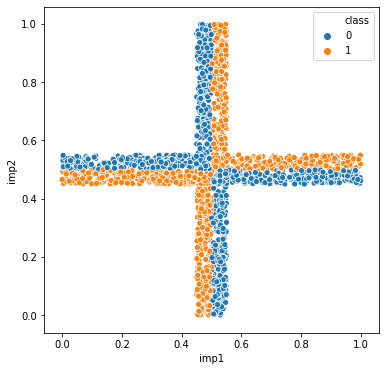

In [154]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(x="imp1", y="imp2", hue='class', data=cross)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(cross.drop(columns=['class']), cross['class'], test_size=0.5, random_state=rand_seed)

In [156]:
RF = RandomForestClassifier(n_estimators=30, max_depth=9)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))

Accuracy = 0.997


In [25]:
lime_intercepts_list_cross, lime_weights_list_cross = evaluate_lime_on_artificial_dataset(RF, cross, n_important_features, n_unimportant_features, correct_weights_abs, probability_threshold=0.50)

Recall on important features = 0.6675
Recall on unimportant features = 0.3325
MAE = 0.2125
Average accuracy = 0.4989
Average coverage = 1.0
Time elapsed while constructing explanations  = 17.8393 seconds


In [255]:
anch_rules_list_cross = evaluate_anchors_on_artificial_dataset(RF, cross, n_important_features, n_unimportant_features, beam_size=4)

Recall on important features = 0.9985
Recall on unimportant features = 0.385
Average accuracy = 0.97
Average coverage = 0.1324
Time elapsed while constructing explanations  = 561.5854 seconds


In [28]:
shapley_values_normalized_cross = evaluate_shap_on_artificial_dataset(RF, cross, n_important_features, n_unimportant_features, correct_weights_abs)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Recall on important features = 0.9935
Recall on unimportant features = 0.051
MAE = 0.0252
Time elapsed while constructing explanations  = 61.6672 seconds


## groups
* class value is a boolean value with 50% probability of 1
* 16 clusters are generated and every adjacent cluster has different class value
* two unimporant random continuous values were added as noise
* the correct explanation (weights) would assign 0.5 weights to both important features and 0s to the unimportant features

In [182]:
groups = pd.DataFrame()

n_important_features = 2
n_unimportant_features = 2
correct_weights_abs = np.array([0.5, 0.5, 0, 0])

#for i in range(n_important_features):
#    groups['imp' + str(int(i+1))] = rand_generator.standard_normal(size=size)
            
size=2000

n_groups = 16
val = 0
imp1 = np.array([])
imp2 = np.array([])
class_array = np.array([])

for i in np.arange(1/(n_groups**0.5)/2, 1, 1/(n_groups**0.5)):
    val = int(not val)
    for j in np.arange(1/(n_groups**0.5)/2, 1, 1/(n_groups**0.5)):
        rand1 = rand_generator.standard_normal(size=size//n_groups)
        rand2 = rand_generator.standard_normal(size=size//n_groups)
        imp1_part = (i + 1/(n_groups**0.5)/2 * rand1/max(abs(rand1)))
        imp2_part = (j + 1/(n_groups**0.5)/2 * rand2/max(abs(rand2)))
        imp1 = np.concatenate((imp1, imp1_part))
        imp2 = np.concatenate((imp2, imp2_part))
        class_array = np.concatenate((class_array, np.tile(val, size//n_groups)))
        val = int(not val)
        

groups['imp1'] = imp1
groups['imp2'] = imp2

# two unimportant continuous features
for i in range(2):
    groups['unimp' + str(int(i+1))] = rand_generator.random_sample(size=len(imp1))
    
groups['class'] = class_array  

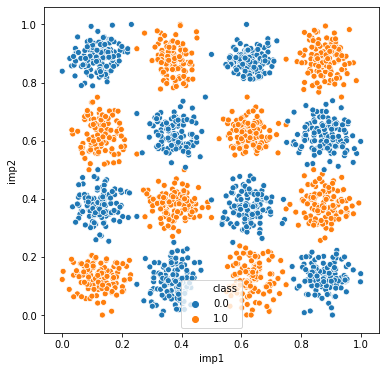

In [183]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(x="imp1", y="imp2", hue='class', data=groups, legend="full")

In [184]:
X_train, X_test, y_train, y_test = train_test_split(groups.drop(columns=['class']), groups['class'], test_size=0.5, random_state=rand_seed)

In [185]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))

Accuracy = 0.94


In [186]:
lime_intercepts_list_groups, lime_weights_list_groups = evaluate_lime_on_artificial_dataset(KNN, groups, n_important_features, n_unimportant_features, correct_weights_abs, probability_threshold=0.50)

Recall on important features = 0.543
Recall on unimportant features = 0.457
MAE = 0.2401
Average accuracy = 0.4973
Average coverage = 1.0
Time elapsed while constructing explanations  = 26.9282 seconds


In [256]:
anch_rules_list_groups = evaluate_anchors_on_artificial_dataset(KNN, groups, n_important_features, n_unimportant_features, beam_size=4)

Recall on important features = 0.989
Recall on unimportant features = 0.827
Average accuracy = 0.8751
Average coverage = 0.0216
Time elapsed while constructing explanations  = 738.2056 seconds


In [188]:
shapley_values_normalized_groups = evaluate_shap_on_artificial_dataset(KNN, groups, n_important_features, n_unimportant_features, correct_weights_abs)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Recall on important features = 0.9495
Recall on unimportant features = 0.266
MAE = 0.0819
Time elapsed while constructing explanations  = 75.9628 seconds
